In [1]:
import sys
sys.path.append("..")
from ultraSoftCrawfish.funcs.pcohp_funcs import get_cheap_pcohp, get_cheap_pcoop
from ultraSoftCrawfish.funcs.pdos_funcs import get_cheap_pdos, get_cheap_dos
from ultraSoftCrawfish.helpers.ElecData import parse_data
import matplotlib.pyplot as plt
from ase.units import Hartree
calc_path = "N2_calc"
data = parse_data(root=calc_path)
# data.norm_projs_t1()
atoms = data.get_atoms()
N_idcs = [i for i, el in enumerate(atoms.get_chemical_symbols()) if el == "N"]

(54, 15, 8)


### Use "get_cheap_dos" for a quick look at the total density of states for your whole system
### (The energy axis is given in units of absolute Hartree by default)

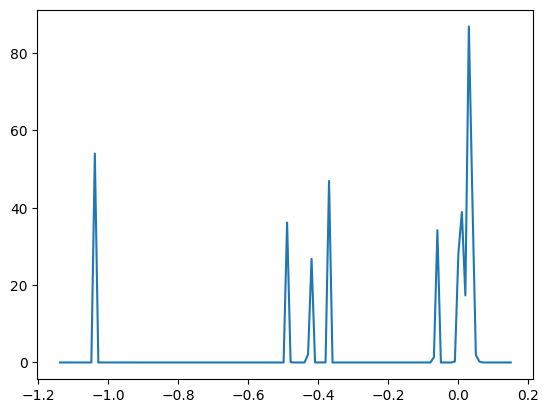

In [33]:
Erange, ctot = get_cheap_dos(data=data)
# Uncomment the next line to have an energy axis with respect to the fermi level
# Erange -= data.get_mu()
# Uncomment the next line to have an energy axis in units eV instead of Hartree
# Erange *= Hartree
plt.plot(Erange, ctot)

### Use "get_cheap_pdos" to shave down DOS information to focus on provided atoms and orbitals. Here we focus on the s orbital of the first Nitrogen. Although without further deconvolution tools we are left to some guess work, it looks like here we have the bonding and antibonding s-sigma at -1 and -0.5 Ha, respectively, and a partial representation of the p-sigma bonding orbital at -0.4 Ha

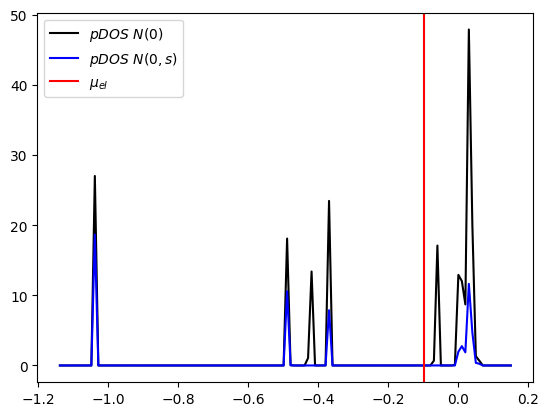

In [34]:
Erange, pdos = get_cheap_pdos([0], data=data)
plt.plot(Erange, pdos, c="black", label = r"$pDOS$ $N(0)$")
Erange, pdos = get_cheap_pdos([0], orbs=["s"], data=data)
plt.plot(Erange, pdos, c="blue", label = r"$pDOS$ $N(0, s)$")
plt.axvline(x=data.get_mu(), c="red", label=r"$\mu_{el}$")
plt.legend()

### Use "get_cheap_pcoop" to deconvolute a pDOS into bonding and antibonding interactions with neighboring atoms. On line 2 of the following code block, the pCOOP between the s orbital of the first nitrogen and all orbitals of the second nitrogen is evaluated. For pCOOP, positive values mean bonding, and negative values mean anti-bonding. Note here that the absolute value of the pCOOP is equal to the corresponding pDOS.

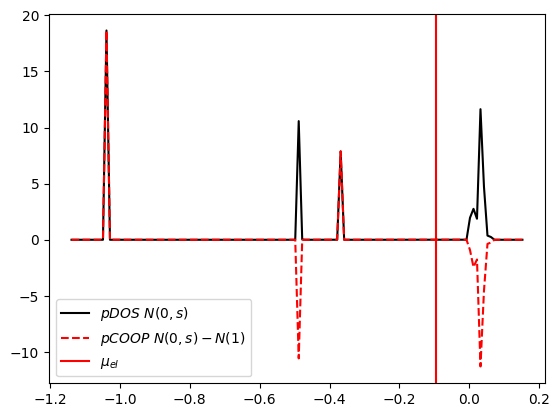

In [35]:
Erange, pdos = get_cheap_pdos([0], orbs=["s"], data=data)
Erange, pcoop = get_cheap_pcoop([0], [1], orbs1=["s"], data=data, Erange=Erange)
plt.plot(Erange, pdos, c="black", label = r"$pDOS$ $N(0, s)$")
plt.plot(Erange, pcoop, c="red", linestyle="dashed", label = r"$pCOOP$ $N(0, s)-N(1)$")
plt.axvline(x=data.get_mu(), c="red", label=r"$\mu_{el}$")
plt.legend()

### As a final step to deconvolute the DOS, we refine our pCOOP to a pCOHP. The difference between the two is that for pCOHP, our y-axis is now in units energy, thus the peaks represent both the amount of electrons involved at a certain energy range, and the strength of the interaction itself. Since negative energies signify stabilizing interactions and positive energies signify de-stabilizing interactions, our convention flips for negative peaks signifying bonding and positive peaks signifying antibonding.

### Now we can clearly see the s-sigma bonding and antibonding at -1 and -0.5, and the bonding orbitals for p-sigma and each pi bond. However, we seem to be missing an antibond peak (that is partially showing at +0.1 Ha), and it is not obvious which one is missing.

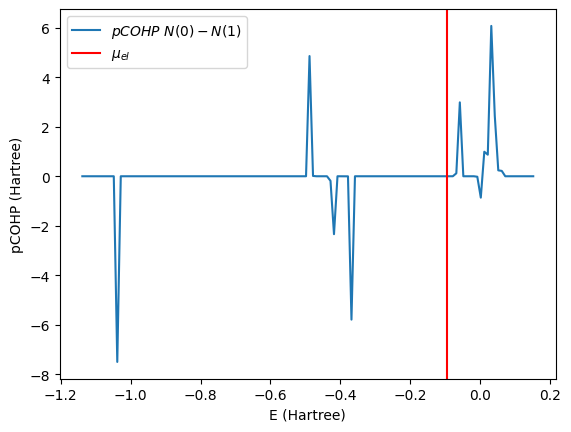

In [36]:
import matplotlib.pyplot as plt
Erange, ctot = get_cheap_pcohp([N_idcs[0]], [N_idcs[1]], calc_path, data=data)
plt.plot(Erange, ctot, label="$pCOHP$ $N(0)-N(1)$")
mu = data.get_mu()
plt.axvline(x=mu, c="red", label=r"$\mu_{el}$")
plt.ylabel("pCOHP (Hartree)")
plt.xlabel("E (Hartree)")
plt.legend()

### We can clarify which of the orbitals above -0.5 Ha belong to which symmetry by requesting specific orbitals for each atom in our pCOHP evaluation. This shows us that the lower energy of the two bonding orbitals belongs to the degenerate pi bonding orbitals, while the higher belongs to the p-sigma orbital (the latter shows up in both the s/s and the p/p pCOHP due to hybridization of the s and pz orbitals involved in this bond).
### The only present anti-bond in our pCOHP analysis is here shown to be our degenerate pi antibonds. This does not mean that the sigma-p antibond does not exist, only that it was not captured by JDFTx's atom-centered projections for nitrogen. The small bump at +0.1 Ha shows that this anti-bonding state was partially captured. As a workaround, we can re-normalize our projections such that sum of the projections for the first M bands (where our calculation has M atomic projections) sum to an equal value, allowing the weak projections captured on this hidden anti-bond to shine (with an appreciable amount of noise). To see this, go back to the first cell and uncomment "data.norm_projs_t1()" and run through this notebook again.

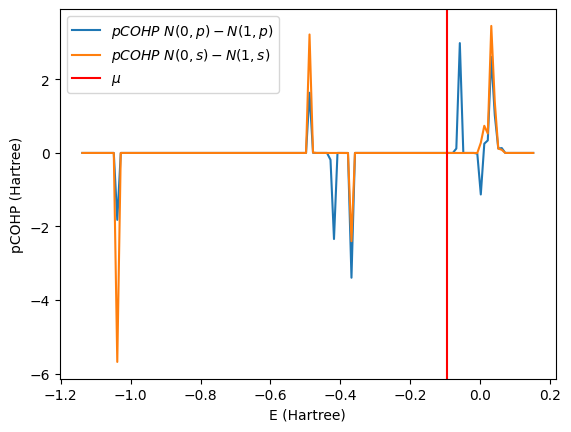

In [37]:
Erange, sigma_pcohp = get_cheap_pcohp([N_idcs[0]], [N_idcs[1]], calc_path, data=data, orbs1="s", orbs2="s")
Erange, pi_pcohp = get_cheap_pcohp([N_idcs[0]], [N_idcs[1]], calc_path, data=data, orbs1="p", orbs2="p")
plt.plot(Erange, pi_pcohp, label="$pCOHP$ $N(0,p)-N(1,p)$")
plt.plot(Erange, sigma_pcohp,label="$pCOHP$ $N(0,s)-N(1,s)$")
mu = data.get_mu()
plt.axvline(x=mu, c="red", label="$\mu$")
plt.ylabel("pCOHP (Hartree)")
plt.xlabel("E (Hartree)")
plt.legend()